# Algorithms in graphics
## Lab 3

[[0, 0, 0, 1, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1]]


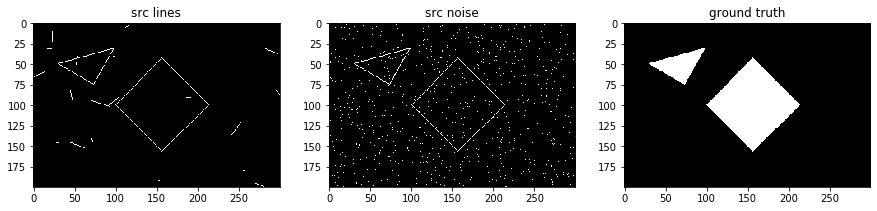

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv

directory = "LabCV/"
f_in_lines = open(os.path.join(directory, "001_line_in.txt"), "r")
image_src_lines = plt.imread(os.path.join(directory, "001_line_src.png"))
image_src_noise = plt.imread(os.path.join(directory, "001_noise_src.png"))
image_gt = plt.imread(os.path.join(directory, "001_line_gt.png"))
image_template = plt.imread(os.path.join(directory, "ref_sqr_3.png"))

f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].set_title("src lines")
ax[1].set_title("src noise")
ax[2].set_title("ground truth")
ax[0].imshow(image_src_lines, cmap='gray')
ax[1].imshow(image_src_noise, cmap='gray')
ax[2].imshow(image_gt, cmap='gray')

N = int(f_in_lines.readline())
basis_figures = []
for i in range(N):
    new_figure = [int(number) for number in f_in_lines.readline().split(',')]
    basis_figures.append(new_figure)
    
print(basis_figures)

In [15]:
def find_figures(N, basis_figures, src_image):
    """ 
    Finds basis_figures at src_image.
    
    Parameters
    ----------
    N : number of basis figures
    basis_figures: basis in format (p1.x, p1.y, p2.x, p2.y, ..., pk.x, pk.y)
    src_image: source image
    
    Returns
    ----------
    list found_figures of M items. Each item is a tuple (basis figure id, shift X, shift Y, scale, rotation_angle)

    """
    
    ## TODO some SOLVER instead of reading correct answer
    found_figures = []
    
    # reading correct answer
    f_out_lines = open(os.path.join(directory, "001_line_out.txt"), "r")
    M = int(f_out_lines.readline())

    for i in range(M):
        new_figure = [int(number) for number in f_out_lines.readline().split(', ')]
        found_figures.append(new_figure)
    
    return M, found_figures

In [16]:
M, found_figures = find_figures(N, basis_figures, image_src_lines)
print(M)
print(found_figures)

2
[[0, 80, -45, 100, 100], [1, 50, -60, 30, 50]]


In [17]:
class Transformation:
    def __init__(self, scale, angle, dx, dy):
        self.scale = scale
        self.angle = angle
        self.dx = dx
        self.dy = dy
        
def draw(inpt, gt, shape, transform, color=255):
    assert (inpt.shape == gt.shape)

    new_shape = shape.copy().astype(np.float)
    
    print(transform.scale, transform.angle)
    # Scale
    new_shape *= transform.scale

    # Rotation
    tmp = new_shape.copy()
    
    for i in [0, 1]:
        new_shape[:, i] = np.cos(transform.angle) * tmp[:, i] \
                         - ((-1)** i) * np.sin(transform.angle) * tmp[:, 1 - i]

    #Shift
    new_shape[:, 0] += transform.dx
    new_shape[:, 1] += transform.dy

    cv.fillPoly(gt, [new_shape.astype(np.int32)], color)
    cv.polylines(inpt, [new_shape.astype(np.int32)], True, color)
    
def plot_results(found_figures, basis_figures, image_src, image_gt):
    image_src_copy = image_src.copy() 
    image_gt_copy = image_gt.copy() 

    for figure in found_figures:
        basis_figure_id = figure[0]
        scale = figure[1]
        rotation_angle = figure[2] / 180 * np.pi

        shift_X = figure[3]
        shift_Y = figure[4]
        
        basis_figure = basis_figures[basis_figure_id]
        basis_points = []
        N = len(basis_figure)
        for i in range(0, N, 2):
            basis_points.append((basis_figure[i], basis_figure[i+1]))
            
        transform = Transformation(scale, rotation_angle, shift_X, shift_Y)
        
        draw(image_src_copy, 
             image_gt_copy,
             np.array(basis_points, dtype=np.int32), 
             transform)
        
    f, ax = plt.subplots(1, 4, figsize=(15,15))
    ax[0].set_title("src result")
    ax[1].set_title("gt result")
    ax[2].set_title("src original")
    ax[3].set_title("gt original")
    ax[0].imshow(image_src_copy, cmap='gray')
    ax[1].imshow(image_gt_copy, cmap='gray')
    ax[2].imshow(image_src, cmap='gray')
    ax[3].imshow(image_gt, cmap='gray')


80 -0.7853981633974483
50 -1.0471975511965976


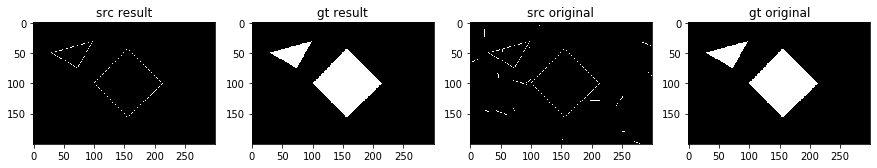

In [18]:
plot_results(found_figures, basis_figures, image_src_lines, image_gt)
plt.show()

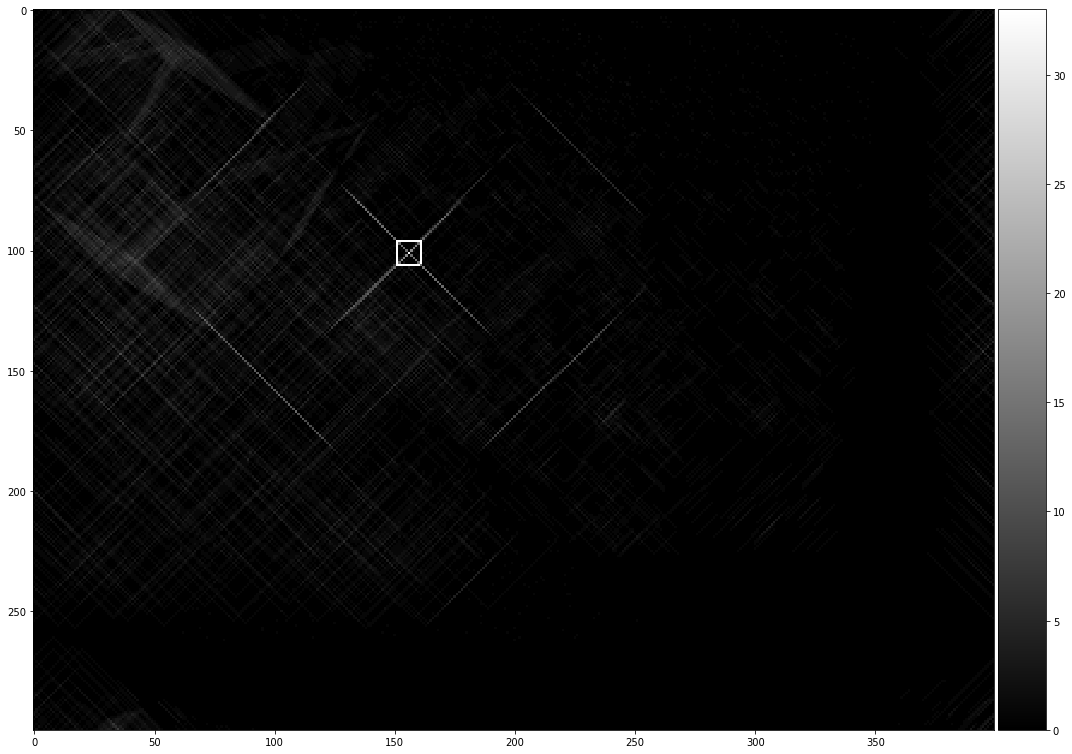

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2b409201f48>)

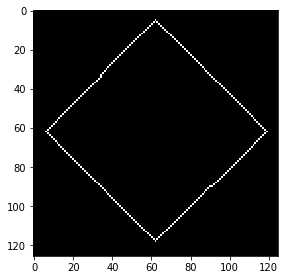

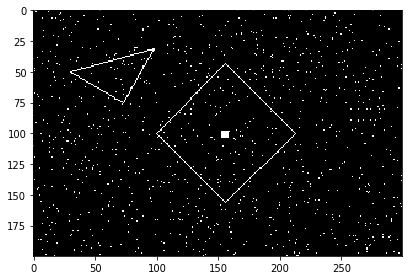

In [19]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve
from skimage import io

def matchTable(im, table):
    """
    :param im: input binary image, for searching template
    :param table: table for template
    :return:
        accumulator with searched votes
    """
    # matches the reference table with the given input
    # image for testing generalized Hough Transform
    m, n = im.shape
    acc = np.zeros((m+100, n+100))  # acc array requires some extra space

    def findGradient(x, y):
        if (x != 0):
            return int(np.rad2deg(np.arctan(int(y/x))))
        else:
            return 0

    for x in range(1, im.shape[0]):
        for y in range(im.shape[1]):

            if im[x, y] != 0:  # boundary point
                theta = findGradient(x, y)
                vectors = table[theta]
                for vector in vectors:
                    acc[vector[0]+x, vector[1]+y] += 1
    return acc

def findMaxima(acc):
    """
    :param acc: accumulator array
    :return:
        maxval: maximum value found
        ridx: row index of the maxval
        cidx: column index of the maxval
    """
    ridx, cidx = np.unravel_index(acc.argmax(), acc.shape)
    return [acc[ridx, cidx], ridx, cidx]

def buildRefTable(img):
    """
    builds the reference table for the given input template image
    :param im: input binary image
    :return:
        table = a reconstructed reference table...
    """
    table = [[0 for x in range(1)] for y in range(90)]  # creating a empty list
    # r will be calculated corresponding to this point
    img_center = [int(img.shape[0]/2), int(img.shape[1]/2)]

    def findAngleDistance(x1, y1):
        x2, y2 = img_center[0], img_center[1]
        r = [(x2-x1), (y2-y1)]
        if (x2-x1 != 0):
            return [int(np.rad2deg(np.arctan(int((y2-y1)/(x2-x1))))), r]
        else:
            return [0, 0]

    filter_size = 1
    for x in range(img.shape[0]-(filter_size-1)):
        for y in range(img.shape[1]-(filter_size-1)):
            if (img[x, y][2] != 0):
                theta, r = findAngleDistance(x, y)
                if (r != 0):
                    table[np.absolute(theta)].append(r)

    for i in range(len(table)):
        table[i].pop(0)

    return table

refim = image_template
im = image_src_noise.copy()

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)
    
# code for drawing bounding-box in accumulator array...
acc[ridx - 5:ridx + 5, cidx - 5] = val
acc[ridx - 5:ridx + 5, cidx + 5] = val
acc[ridx - 5, cidx - 5:cidx + 5] = val
acc[ridx + 5, cidx - 5:cidx + 5] = val

plt.figure(1, figsize=(15, 15))
imshow(acc, cmap='gray')
plt.show()

# find the half-width and height of template
hheight = np.floor(refim.shape[0] / 2) + 1
hwidth = np.floor(refim.shape[1] / 2) + 1

# find coordinates of the box
rstart = int(max(ridx - hheight, 1))
rend = int(min(ridx + hheight, im.shape[0] - 1))
cstart = int(max(cidx - hwidth, 1))
cend = int(min(cidx + hwidth, im.shape[1] - 1))
rcenter = int((rstart + rend) / 2)
ccenter = int((cstart + cend) / 2)

# draw the point
im[rcenter-3:rcenter+3, ccenter-3:ccenter+3] = 1

# show the image
plt.figure(2), imshow(refim, cmap='gray')
plt.figure(3), imshow(im, cmap='gray')
#plt.show()
